# BERT using Pytorch

In [4]:
!pip install transformers

In [6]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample
from tqdm import tqdm
import warnings
%matplotlib inline
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
df = pd.read_csv('/kaggle/input/just-a-hinge/Final_features.csv')
df['processed_text'] = df['processed_text'].astype('str')
df['processed_text'] = df['processed_text'].apply(lambda x: x.lower())
df = resample(df, random_state = RANDOM_SEED)

In [8]:
df.head()

,qid,question_text,target,processed_text,embed_text,words_num,words_num_unique,char_num,stopwords_num,punctuation_num,titlecase_num,average_word_len,polarity,subjectivity,length
121958,17df11bf9b1888d64add,I feel something missing in my relationship. I...,0,i feel something missing in my relationship i ...,I feel something missing in my relationship . ...,51,35,233,35,6,6,3.588235,-0.253125,0.440625,246
671155,837181f0407fd112a05c,"What do Socrates, Thomas Kuhn and Karl Popper ...",0,what do socrates thomas kuhn and karl popper h...,"What do Socrates , Thomas Kuhn and Karl Poppe...",11,11,61,5,2,6,4.636364,-0.300000,0.500000,65
131932,19d09fe4bbabf16eb347,What song played in the movie of the gifted wh...,0,what song played in the movie of the gifted wh...,What song played in the movie of the gifted wh...,15,14,75,7,1,2,4.066667,0.156250,0.750000,77
259178,32b9bf37edd829ffe658,What are the biggest myths about Adolf Hitler?,0,what are the biggest myth about adolf hitler,What are the biggest myths about Adolf Hitler ?,8,8,46,4,1,3,4.875000,0.000000,0.000000,48
110268,1595cbbad9c20d3d791a,How can the ViewSonic PA503S 3600 lumens SVGA ...,0,how can the viewsonic pa503s 3600 lumen svga h...,How can the ViewSonic PA503S 3600 lumens SVGA ...,14,14,95,4,1,1,5.857143,0.000000,0.000000,97


In [9]:
df['target'].value_counts()

0    1225551
1      80571
Name: target, dtype: int64

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [20]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
# encoding.keys()

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [22]:
token_lens = []
for txt in tqdm(df.processed_text):
    tokens = tokenizer.encode(txt, max_length=512, truncation = True)
    token_lens.append(len(tokens))

100%|██████████| 1306122/1306122 [10:19<00:00, 2109.65it/s]


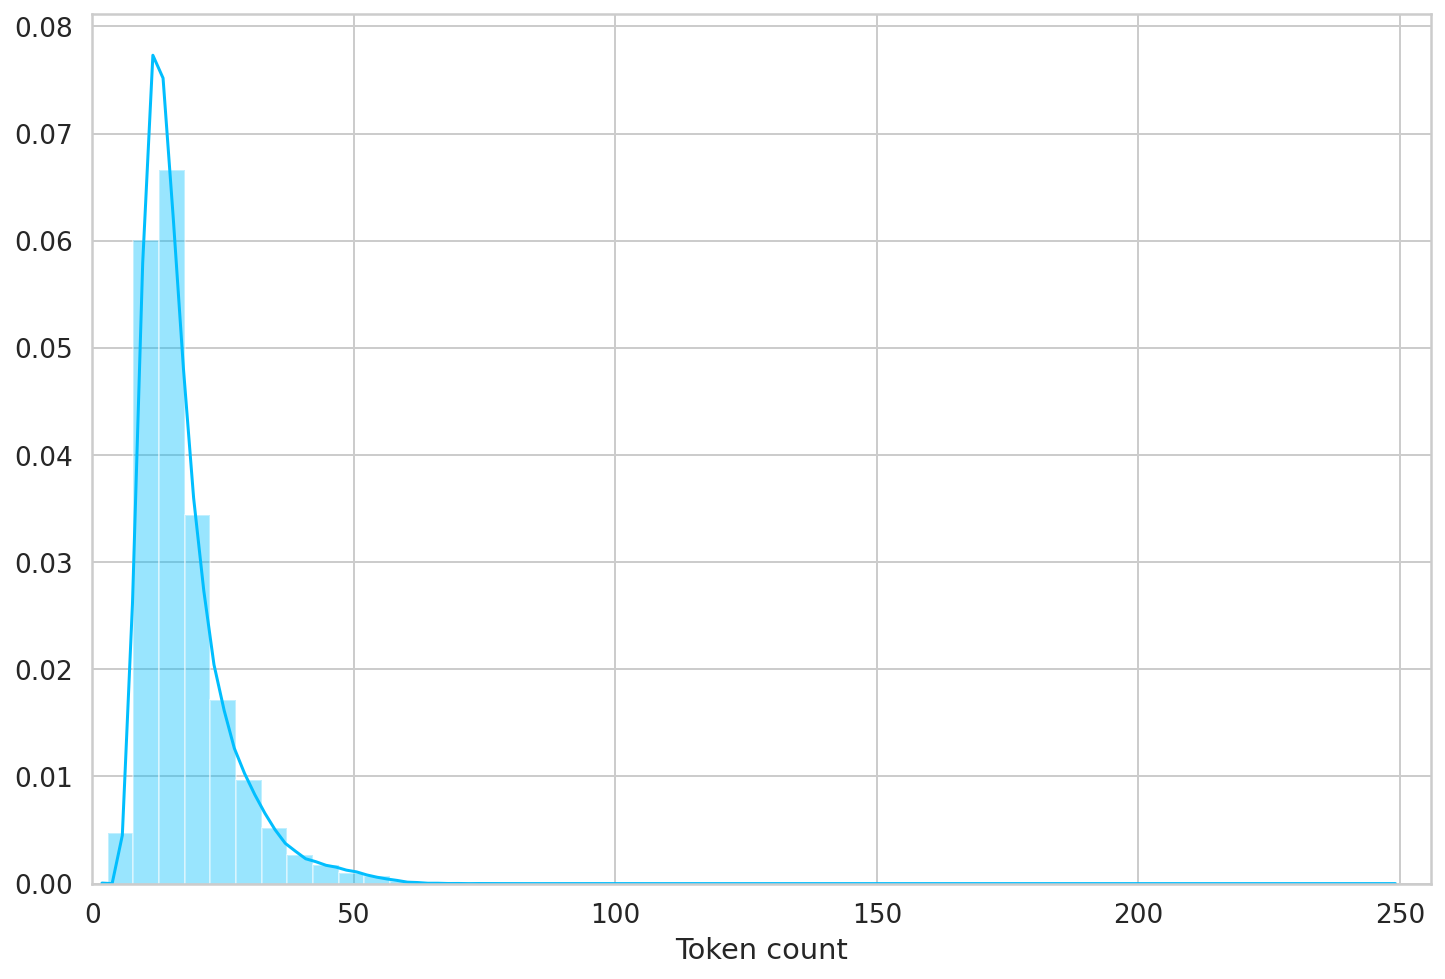

In [23]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [24]:
MAX_LEN = 160

In [25]:
class GPquestionDataset(Dataset):
    
    def __init__(self, questions, targets, tokenizer, max_len):
        self.questions = questions
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.questions)
    def __getitem__(self, item):
        question = str(self.questions[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          question,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True  
        )
        return {
          'question_text': question,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
      }

In [26]:
df_train, df_test = train_test_split(
  df,
  test_size = 0.4,
  random_state = RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size = 0.6,
  random_state = RANDOM_SEED
)
print (df_train.shape, df_val.shape, df_test.shape)

(783673, 15) (208979, 15) (313470, 15)


In [27]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPquestionDataset(
      questions = df.processed_text.to_numpy(),
      targets = df.target.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
    )
    return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 0
    )
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [28]:
len(train_data_loader)

48980

In [29]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['question_text', 'input_ids', 'attention_mask', 'targets'])

In [30]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [32]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [33]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [34]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [35]:
bert_model.config.hidden_size

768

In [36]:
pooled_output.shape

torch.Size([1, 768])

In [37]:
class QuestionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(QuestionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [38]:
model = QuestionClassifier(2)
model = model.to(device)

In [39]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [40]:
model(input_ids, attention_mask)

tensor([[ 0.7471, -0.0928],
        [ 0.4551, -0.8686],
        [ 0.2602, -0.3544],
        [ 0.9082, -0.6059],
        [ 0.8285, -0.3872],
        [ 0.0752, -0.5211],
        [ 0.4663, -0.6428],
        [ 0.0187,  0.0039],
        [ 0.4096, -0.3691],
        [ 0.1233, -0.0456],
        [ 0.4300, -0.4621],
        [ 0.7598,  0.1754],
        [ 0.5538, -1.1269],
        [ 0.3022, -0.8219],
        [ 0.6357, -0.1506],
        [ 0.4392, -0.2036]], device='cuda:0', grad_fn=<AddmmBackward>)

In [42]:
EPOCHS = 1
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [43]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):  
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/1
----------
Train loss 0.16261364587840482 accuracy 0.9489161933612617
Val   loss 0.13248102216770624 accuracy 0.9554931356739194

CPU times: user 2h 58min 35s, sys: 1h 20min 1s, total: 4h 18min 37s
Wall time: 4h 20min 36s


In [48]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print (test_acc)

tensor(0.9552, device='cuda:0', dtype=torch.float64)


In [49]:
def get_predictions(model, data_loader):
    model = model.eval()
    question_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["question_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            question_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return question_texts, predictions, prediction_probs, real_values

In [50]:
y_question_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [89]:
# First 10 predictions and text
i = 0
for t, pred, prob in zip(y_question_texts, y_pred, y_pred_probs):
    print (t, end = "   ")
    print (pred, end = "   ")
    print (prob)
    i+=1
    if i == 10:
        break

what is the site allthefallen ninja is it safe   tensor(0)   tensor([ 3.0678, -3.4646])
what influenced your desire to work in the field of peace and conflict resolution   tensor(0)   tensor([ 3.2062, -3.6495])
a number is multiplied by half of itself and then 32 it is added to the product if the final result is 130 then find the original number   tensor(0)   tensor([ 3.1431, -3.5542])
what do i need to do if i travel to india   tensor(0)   tensor([ 3.2033, -3.6436])
do some loser live a good life   tensor(0)   tensor([ 2.6768, -3.0873])
can pakistan be perceived a an abandoned child of akhand bharat who grows up to become a confused directionless and lost adult   tensor(0)   tensor([ 1.0097, -1.9286])
is compound interest a sin   tensor(0)   tensor([ 3.0515, -3.4466])
what are some indigenous value   tensor(0)   tensor([ 3.0996, -3.5011])
if sweden will be a country full of africans like iraq can it be a first world country   tensor(0)   tensor([ 0.5161, -1.1352])
what 4k tv do you th

In [55]:
# Classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    294093
           1       0.67      0.55      0.60     19377

    accuracy                           0.96    313470
   macro avg       0.82      0.77      0.79    313470
weighted avg       0.95      0.96      0.95    313470



In [88]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ("True Negative : ", tn)
print ("False Positive : ", fp)
print ("False Negative : ", fn)
print ("true positive : ", tp)

True Negative :  288739
False Positive :  5354
False Negative :  8684
true positive :  10693


In [82]:
# f1_score
print (f1_score(y_test, y_pred))

0.6037149954832881
